# House Price ML — Starter Notebook

This notebook trains and compares two regression models on a housing dataset.
- Preferred input: `data/house_prices.csv` (your custom dataset).
- Fallback: use **sklearn California Housing** dataset (auto-load).

**Pipeline**
1. Load data (local CSV or sklearn fallback)
2. Quick EDA (head/info/describe + missing values)
3. Train/validation split
4. Preprocessing (numeric impute + scaling)
5. Models: Linear Regression, Random Forest
6. Metrics: MAE, RMSE, R² (on validation set)
7. Save plots to `plots/` and model to `model.pkl`

In [36]:
import os
os.makedirs("plots", exist_ok=True)


In [37]:
import os
print(os.listdir("/kaggle/input"))


['hpricedata', 'house-prices-csv']


In [38]:
import os
print(os.listdir("/kaggle/input/house-prices-csv"))
print(os.listdir("/kaggle/input/hpricedata"))


['house_prices.csv']
['house_prices.csv']


In [39]:
df = pd.read_csv("/kaggle/input/hpricedata/house_prices.csv")
df.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,price
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [40]:
# 0) Imports
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [41]:
# 1) Load data
# Try to load your own CSV first (place a file at data/house_prices.csv with a 'price' target column).
# If not found, fall back to sklearn California Housing dataset.
csv_path = 'data/house_prices.csv'

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print(f'Loaded local CSV: {csv_path}')
else:
    from sklearn.datasets import fetch_california_housing
    cali = fetch_california_housing(as_frame=True)
    df = cali.frame.copy()
    # create a "price" column (target) and keep others as features
    df = df.rename(columns={'MedHouseVal': 'price'})
    print('Loaded sklearn California Housing dataset as fallback.')

print('Shape:', df.shape)
df.head()

Loaded sklearn California Housing dataset as fallback.
Shape: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [42]:
# 2) Quick EDA
display(df.head())
display(df.describe().T)

print('\nData types:')
print(df.dtypes)

# Missing values summary
missing = df.isna().sum().sort_values(ascending=False)
print('\nMissing values per column:')
print(missing[missing > 0] if missing.sum() > 0 else 'No missing values detected.')

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
price,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010



Data types:
MedInc        float64
HouseAge      float64
AveRooms      float64
AveBedrms     float64
Population    float64
AveOccup      float64
Latitude      float64
Longitude     float64
price         float64
dtype: object

Missing values per column:
No missing values detected.


In [43]:
# 3) Define target and features
# Try to detect a reasonable target column. Default to 'price'.
candidate_targets = ['price', 'SalePrice', 'target']
target_col = None
for c in candidate_targets:
    if c in df.columns:
        target_col = c
        break

if target_col is None:
    # If none found, assume the last column is the target (not ideal, but makes notebook runnable).
    target_col = df.columns[-1]
    print(f'No standard target found; using last column as target: {target_col}')

y = df[target_col]
X = df.drop(columns=[target_col])

# Keep only numeric features for this simple baseline
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X = X[num_cols]
print('Using numeric features:', num_cols[:10], '...' if len(num_cols) > 10 else '')

Using numeric features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'] 


In [44]:
# 4) Train/validation split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_valid.shape

((16512, 8), (4128, 8))

In [45]:
# 5) Preprocessing pipeline for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocess = ColumnTransformer(
    transformers=[('num', numeric_transformer, X_train.columns)]
)

In [46]:
# 6) Define models
linreg = Pipeline(steps=[('preprocess', preprocess),
                        ('model', LinearRegression())])

rf = Pipeline(steps=[('preprocess', preprocess),
                     ('model', RandomForestRegressor(
                         n_estimators=300, random_state=42, n_jobs=-1
                     ))])

In [47]:
# 7) Train
linreg.fit(X_train, y_train)
rf.fit(X_train, y_train)
print('Training completed.')

Training completed.


In [48]:
# 8) Evaluate
def eval_regression(model, Xv, yv, name='model'):
    preds = model.predict(Xv)
    mae = mean_absolute_error(yv, preds)
    rmse = mean_squared_error(yv, preds, squared=False)
    r2 = r2_score(yv, preds)
    print(f'[{name}] MAE={mae:.4f}  RMSE={rmse:.4f}  R2={r2:.4f}')
    return {'name': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2}

res_lin = eval_regression(linreg, X_valid, y_valid, 'LinearRegression')
res_rf  = eval_regression(rf, X_valid, y_valid, 'RandomForest')

results = pd.DataFrame([res_lin, res_rf])
results

[LinearRegression] MAE=0.5332  RMSE=0.7456  R2=0.5758
[RandomForest] MAE=0.3265  RMSE=0.5032  R2=0.8067


,name,MAE,RMSE,R2
0,LinearRegression,0.533200,0.745581,0.575788
1,RandomForest,0.326531,0.503228,0.806748


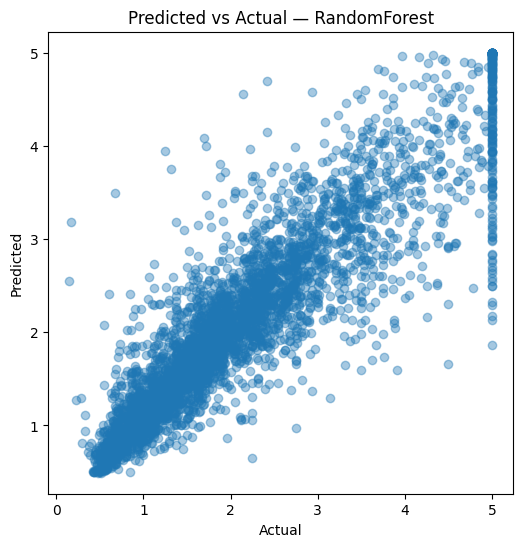

Plot saved to plots/pred_vs_actual.png


In [49]:
# 9) Plot: Predicted vs Actual (for the best model)
best = res_rf if res_rf['RMSE'] < res_lin['RMSE'] else res_lin
best_name = best['name']
best_model = rf if best_name == 'RandomForest' else linreg

preds = best_model.predict(X_valid)

plt.figure(figsize=(6,6))
plt.scatter(y_valid, preds, alpha=0.4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Predicted vs Actual — {best_name}')
plot_path = 'plots/pred_vs_actual.png'
plt.savefig(plot_path, bbox_inches='tight', dpi=150)
plt.show()

print(f'Plot saved to {plot_path}')

MedInc        0.525736
AveOccup      0.138081
Longitude     0.088547
Latitude      0.088531
HouseAge      0.054213
AveRooms      0.044668
Population    0.030557
AveBedrms     0.029668
dtype: float64

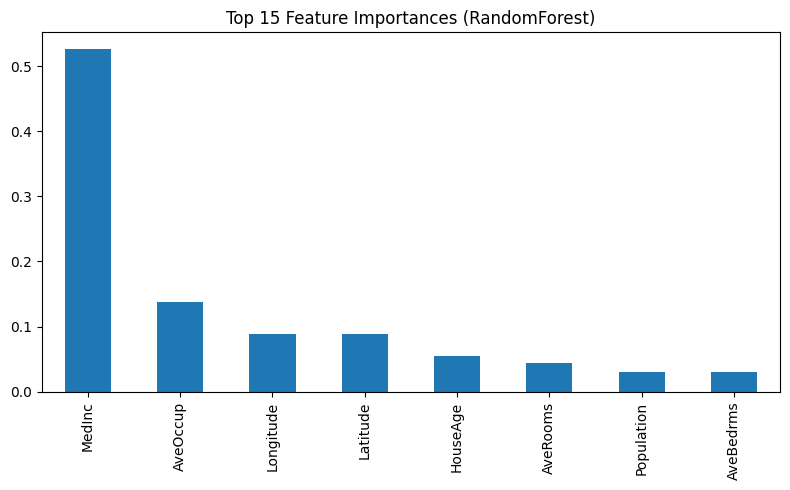

Plot saved to plots/feature_importance.png


In [50]:
# 10) (Optional) Feature importance for RandomForest
if best_name == 'RandomForest':
    # Extract feature importances after preprocessing
    rf_model = best_model.named_steps['model']
    feature_names = best_model.named_steps['preprocess'].transformers_[0][2]
    importances = pd.Series(rf_model.feature_importances_, index=feature_names).sort_values(ascending=False)
    display(importances.head(15))

    plt.figure(figsize=(8,5))
    importances.head(15).plot(kind='bar')
    plt.title('Top 15 Feature Importances (RandomForest)')
    plt.tight_layout()
    plot_path2 = 'plots/feature_importance.png'
    plt.savefig(plot_path2, bbox_inches='tight', dpi=150)
    plt.show()
    print(f'Plot saved to {plot_path2}')
else:
    print('Feature importances shown only for RandomForest.')

In [51]:
# 11) Save best model
joblib.dump(best_model, 'model.pkl')
print('Saved model to model.pkl')

Saved model to model.pkl
